In [1]:
pip install --upgrade ipywidgets sentence-transformers

StatementMeta(, 73d1abee-9e29-4fa8-9f36-292cf5186f18, 3, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 2.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 43.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 92.1 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 154.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 167.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 167.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 3.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 57.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━

# Section 2: Translation Bias
In this section, we demonstrate an example of biases that happens in language models and sentence embedding. In particular, we show that the language models occasionally have gender assumptions for different occupations. 

In the following section:
- **LLM: Direct Inquiry on Assumptions** We first ask _gpt-3.5-turbo_ about feminine and masculine occupations. In this section, it is we clearly see the pre-assumptions this language model has on categorizing the occupations.

- **LLM: Translation from Gender-neutral Languages** On second part, we turn the above occupations to simple third-person sentences. English language assigns gender to the third-person pronouns, while there are other languages such as _Finnish_ and _Persian (Farsi)_ that have gender-neutral third-person pronouns and the career-titles are not gender-dependent, either. We prompt _gpt-3.5-turbo_ for translating from English to the gender-neutral language, and then translate it back to English. Ideally, the translation should look like _s/he_. However, what we observe is the model assumption of the gender varies based on the occupation.

- **Sentence Embedding: Measuring the Bias**: Since the translation query has some randomness and selects the gender based on LM latent probabilities, we use embedding vectors to calculate numbers for measuring the discussed translation bias.


BiasEvaluation_p1 - Parts A and B require Open-AI key and the API calls take some time. You can skip running this notebook, observe the results, and just load the prepared dataset on the next Notebook.

**BiasEvaluation_p2 -** Part C loads the prepared dataset on Notebook 1 and uses sentence embedding to assess the biases in a smaller sentence embedding model.

In [2]:
# import useful libraries
import pandas as pd
import json
import time
import pickle
import os
import subprocess
import random

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

StatementMeta(, 73d1abee-9e29-4fa8-9f36-292cf5186f18, 4, Finished, Available)

In [3]:
# embedding
from sentence_transformers import SentenceTransformer
sentence_embedding_MODEL = "paraphrase-multilingual-mpnet-base-v2"

StatementMeta(, 73d1abee-9e29-4fa8-9f36-292cf5186f18, 5, Finished, Available)

## C. Sentence Embedding: Measuring the Bias

In [4]:
# hf_embedding_model='paraphrase-multilingual-mpnet-base-v2' #Multilingual version of paraphrase-mpnet-base-v2, trained on parallel data for 50+ languages.
sentxformer = SentenceTransformer('sentence-transformers/' + sentence_embedding_MODEL)

# read the prepared dataset
df_translate = pd.read_parquet("/lakehouse/default/Files/occupation_translations.parquet")
df_translate.head(3)

StatementMeta(, 73d1abee-9e29-4fa8-9f36-292cf5186f18, 6, Finished, Available)

,occupation,gpt_gender,en_she,en_he,en_they,gpt_stereotype,gpt_antistereotype,en2fin_she,en2fin_he,fin2en_she,fin2en_he,en2fa_she,en2fa_he,fa2en_she,fa2en_he
0,nanny,F,She is a nanny,He is a nanny,They are a nanny,She is a nanny,He is a nanny,Hän on lastenhoitaja.,Hän on lastenhoitaja.,She is a babysitter.,She is a babysitter.,او یک پرستار بچه است.,او یک پرستار بچه است.,She is a pediatric nurse.,She is a pediatric nurse.
1,nurse,F,She is a nurse,He is a nurse,They are a nurse,She is a nurse,He is a nurse,Hän on sairaanhoitaja.,Hän on sairaanhoitaja.,She is a nurse.,She is a nurse.,او یک پرستار است.,او یک پرستار است.,She is a nurse.,She is a nurse.
2,teacher,F,She is a teacher,He is a teacher,They are a teacher,She is a teacher,He is a teacher,Hän on opettaja.,Hän on opettaja.,"""He is a teacher.""","""He is a teacher.""",او یک معلم است.,او یک معلم است.,He is a teacher.,He is a teacher.


StatementMeta(, 73d1abee-9e29-4fa8-9f36-292cf5186f18, 7, Finished, Available)

StatementMeta(, 73d1abee-9e29-4fa8-9f36-292cf5186f18, 8, Finished, Available)

StatementMeta(, 73d1abee-9e29-4fa8-9f36-292cf5186f18, 9, Finished, Available)

**Bias-Assessment by Comparing Similarities**: We evaluate the gender-assumptions embedded in the sentence embedding model by comparing the vector similarity of a gender-neutural form with female vs. male versions using vectors-dot-product.

**Example**:
Gender-Neutral Embedding (e.g., Finnish) is more similar to Male, Female, or Plural versions?

In [12]:
eng_rec = df_translate.loc[72]
nurse_rec = df_translate.loc[1]

StatementMeta(, 73d1abee-9e29-4fa8-9f36-292cf5186f18, 17, Finished, Available)

- They (English Only):

In [13]:
print("-----")
rec = eng_rec
print(rec["en_she"], ">", rec["en_they"], " => Similarity: ", np.dot(sentxformer.encode(rec["en_she"]),sentxformer.encode(rec["en_they"])))
print(rec["en_he"], ">", rec["en_they"], " => Similarity: ", np.dot(sentxformer.encode(rec["en_he"]),sentxformer.encode(rec["en_they"])))

print("-----")
rec = nurse_rec
print(rec["en_she"], ">", rec["en_they"], " => Similarity: ", np.dot(sentxformer.encode(rec["en_she"]),sentxformer.encode(rec["en_they"])))
print(rec["en_he"], ">", rec["en_they"], " => Similarity: ", np.dot(sentxformer.encode(rec["en_he"]),sentxformer.encode(rec["en_they"])))


StatementMeta(, 73d1abee-9e29-4fa8-9f36-292cf5186f18, 18, Finished, Available)

-----
She is an engineer > They are an engineer  => Similarity:  7.686013
He is an engineer > They are an engineer  => Similarity:  8.464863
-----
She is a nurse > They are a nurse  => Similarity:  9.769493
He is a nurse > They are a nurse  => Similarity:  8.7126665


- Finnish:

In [14]:
print("-----")
rec = eng_rec
print(rec["en_she"], ">", rec["en2fin_she"], " => Similarity: ", np.dot(sentxformer.encode(rec["en_she"]),sentxformer.encode(rec["en2fin_she"])))
print(rec["en_he"], ">", rec["en2fin_he"], " => Similarity: ", np.dot(sentxformer.encode(rec["en_he"]),sentxformer.encode(rec["en2fin_he"])))

print("-----")
rec = nurse_rec
print(rec["en_she"], ">", rec["en2fin_she"], " => Similarity: ", np.dot(sentxformer.encode(rec["en_she"]),sentxformer.encode(rec["en2fin_she"])))
print(rec["en_he"], ">", rec["en2fin_he"], " => Similarity: ", np.dot(sentxformer.encode(rec["en_he"]),sentxformer.encode(rec["en2fin_he"])))

StatementMeta(, 73d1abee-9e29-4fa8-9f36-292cf5186f18, 19, Finished, Available)

-----
She is an engineer > Hän on insinööri.  => Similarity:  7.826704
He is an engineer > Hän on insinööri.  => Similarity:  9.777098
-----
She is a nurse > Hän on sairaanhoitaja.  => Similarity:  10.389578
He is a nurse > Hän on sairaanhoitaja.  => Similarity:  8.766188


- Persian:

In [15]:
# engineer
print("-----")
rec = eng_rec
print(rec["en_she"], ">", rec["en2fa_she"], " => Similarity: ", np.dot(sentxformer.encode(rec["en_she"]),sentxformer.encode(rec["en2fa_she"])))
print(rec["en_he"], ">", rec["en2fa_he"], " => Similarity: ", np.dot(sentxformer.encode(rec["en_he"]),sentxformer.encode(rec["en2fa_he"])))

print("-----")
rec = nurse_rec
print(rec["en_she"], ">", rec["en2fa_she"], " => Similarity: ", np.dot(sentxformer.encode(rec["en_she"]),sentxformer.encode(rec["en2fa_she"])))
print(rec["en_he"], ">", rec["en2fa_he"], " => Similarity: ", np.dot(sentxformer.encode(rec["en_he"]),sentxformer.encode(rec["en2fa_he"])))

StatementMeta(, 73d1abee-9e29-4fa8-9f36-292cf5186f18, 20, Finished, Available)

-----
She is an engineer > او یک مهندس است.  => Similarity:  7.634477
He is an engineer > او یک مهندس است.  => Similarity:  10.3243
-----
She is a nurse > او یک پرستار است.  => Similarity:  10.58383
He is a nurse > او یک پرستار است.  => Similarity:  8.734617


### C1. Embedding Vectors

In [16]:
# only keep the one with equal male/female translations:
df_assess = df_translate[df_translate["en2fin_she"]==df_translate["en2fin_he"]].reset_index(drop=True)
df_assess = df_assess[df_assess["en2fa_she"]==df_assess["en2fa_he"]].reset_index(drop=True)
df_assess.groupby("gpt_gender").count()["occupation"]

StatementMeta(, 73d1abee-9e29-4fa8-9f36-292cf5186f18, 21, Finished, Available)

gpt_gender
F    41
M    43
Name: occupation, dtype: int64

In [17]:
# drop random 2 Masculine records to have equal number of gpt-assessed records
random.seed(342)
f_index = df_assess.index[df_assess['gpt_gender'] == "F"].tolist()
m_index = random.sample(df_assess.index[df_assess['gpt_gender'] == "M"].tolist(), len(f_index))

df_assess = df_assess.loc[f_index+m_index].reset_index(drop=True)
df_assess.groupby("gpt_gender").count()["occupation"]

StatementMeta(, 73d1abee-9e29-4fa8-9f36-292cf5186f18, 22, Finished, Available)

gpt_gender
F    41
M    41
Name: occupation, dtype: int64

In [18]:
# calculate embedding for english female & male versions
df_assess["en_he_vec"] = sentxformer.encode(df_assess["en_he"]).tolist()
df_assess["en_she_vec"] = sentxformer.encode(df_assess["en_she"]).tolist()

StatementMeta(, 73d1abee-9e29-4fa8-9f36-292cf5186f18, 23, Finished, Available)

In [19]:
def get_feminine_sentiment(sentences, en_she_vecs, en_he_vecs):
    sentence_vectors  = sentxformer.encode(sentences).tolist()
    # calculate similarity by dot-product
    female_similarity =[np.array(x).dot(np.array(y)) for x, y in zip(en_she_vecs, sentence_vectors)]
    male_similarity   =[np.array(x).dot(np.array(y)) for x, y in zip(en_he_vecs, sentence_vectors)]
    feminine_sentiment=[f-m for f,m in zip(female_similarity, male_similarity)]
    print("Tendency to female-translation vs. GPT-labels:", np.mean(feminine_sentiment))
    return female_similarity, male_similarity, feminine_sentiment

StatementMeta(, 73d1abee-9e29-4fa8-9f36-292cf5186f18, 24, Finished, Available)

- **They (English)**: We observe that the biases agree with the GPT labels.

In [20]:
female_similarity, male_similarity, feminine_sentiment = get_feminine_sentiment(
    df_assess["en_they"], df_assess["en_she_vec"], df_assess["en_he_vec"])

StatementMeta(, 73d1abee-9e29-4fa8-9f36-292cf5186f18, 25, Finished, Available)

Tendency to female-translation vs. GPT-labels: -0.03554582935526297


In [21]:
they_data = pd.DataFrame({
    "occupation":df_assess.occupation, "gpt_gender":df_assess.gpt_gender,
    "category":["they"]*df_assess.shape[0],"female_similarity":female_similarity,
    "male_similarity":male_similarity, "feminine_sentiment":feminine_sentiment})

they_data.groupby("gpt_gender")["feminine_sentiment"].mean()

StatementMeta(, 73d1abee-9e29-4fa8-9f36-292cf5186f18, 26, Finished, Available)

gpt_gender
F    0.343655
M   -0.414747
Name: feminine_sentiment, dtype: float64

- **Finnish**

In [22]:
female_similarity, male_similarity, feminine_sentiment = get_feminine_sentiment(
    df_assess["fin2en_he"], df_assess["en_she_vec"], df_assess["en_he_vec"])

StatementMeta(, 73d1abee-9e29-4fa8-9f36-292cf5186f18, 27, Finished, Available)

Tendency to female-translation vs. GPT-labels: -0.5620869617132964


In [23]:
fin_data = pd.DataFrame({
    "occupation":df_assess.occupation, "gpt_gender":df_assess.gpt_gender,
    "category":["Fin"]*df_assess.shape[0],"female_similarity":female_similarity,
    "male_similarity":male_similarity, "feminine_sentiment":feminine_sentiment})

fin_data.groupby("gpt_gender")["feminine_sentiment"].mean()

StatementMeta(, 73d1abee-9e29-4fa8-9f36-292cf5186f18, 28, Finished, Available)

gpt_gender
F    0.907529
M   -2.031703
Name: feminine_sentiment, dtype: float64

In [24]:
# feminine occupations based on sentence embedding
fin_data.loc[(fin_data["feminine_sentiment"]>0),["occupation","gpt_gender"]]

StatementMeta(, 73d1abee-9e29-4fa8-9f36-292cf5186f18, 29, Finished, Available)

,occupation,gpt_gender
0,nanny,F
1,nurse,F
3,receptionist,F
4,secretary,F
5,makeup artist,F
6,fashion designer,F
7,interior decorator,F
10,waitress,F
11,hostess,F
12,flight attendant,F


- **Farsi/Persian**

In [25]:
female_similarity, male_similarity, feminine_sentiment = get_feminine_sentiment(
    df_assess["fa2en_she"], df_assess["en_she_vec"], df_assess["en_he_vec"])

StatementMeta(, 73d1abee-9e29-4fa8-9f36-292cf5186f18, 30, Finished, Available)

Tendency to female-translation vs. GPT-labels: -1.8065705804963996


In [26]:
fa_data = pd.DataFrame({
    "occupation":df_assess.occupation, "gpt_gender":df_assess.gpt_gender,
    "category":["Fa"]*df_assess.shape[0],"female_similarity":female_similarity,
    "male_similarity":male_similarity, "feminine_sentiment":feminine_sentiment})

fa_data.groupby("gpt_gender")["feminine_sentiment"].mean()

StatementMeta(, 73d1abee-9e29-4fa8-9f36-292cf5186f18, 31, Finished, Available)

gpt_gender
F   -1.198979
M   -2.414163
Name: feminine_sentiment, dtype: float64

In [27]:
# feminine occupations based on sentence embedding
fa_data.loc[(fa_data["feminine_sentiment"]>0),["occupation","gpt_gender"]]

StatementMeta(, 73d1abee-9e29-4fa8-9f36-292cf5186f18, 32, Finished, Available)

,occupation,gpt_gender
0,nanny,F
1,nurse,F
5,makeup artist,F
7,interior decorator,F
10,waitress,F
15,yoga instructor,F
16,pilates instructor,F
17,zumba instructor,F
18,ballet dancer,F
21,beauty consultant,F


## C2. Visualization

StatementMeta(, 73d1abee-9e29-4fa8-9f36-292cf5186f18, 33, Finished, Available)

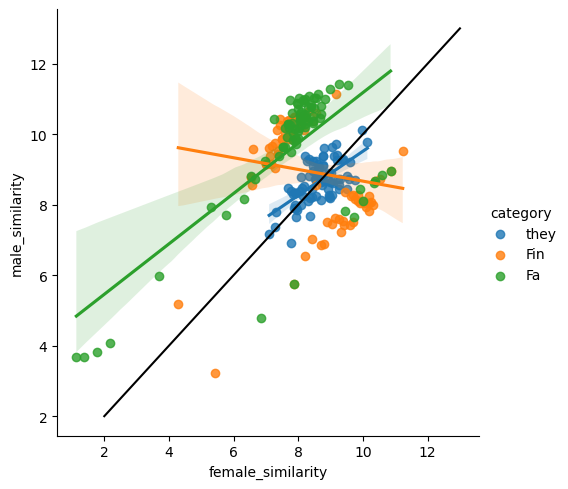

In [28]:
df_plot = pd.concat([they_data, fin_data, fa_data])

g=sns.lmplot(
    x="female_similarity", 
    y="male_similarity", 
    hue="category", 
    data=df_plot,  
    legend=True
)

# the black line shows the ideal pattern on an unbiased LM
plt.plot([2, 13], [2, 13], color='black')